<a href="https://colab.research.google.com/github/Ayu-Raj/Flight-Delay-Prediction/blob/master/unisys_project_Predict_Flight_Delay_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting G-Drive for data set

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing Required Libraries

In [ ]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import Ridge
from sklearn import metrics, linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read Data-Set

In [ ]:
airlines_data = pd.read_csv('/content/gdrive/My Drive/unisys/airlines.csv')

In [ ]:
airlines_data.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [ ]:
airports = pd.read_csv('/content/gdrive/My Drive/unisys/airports.csv')

In [ ]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/unisys/flights.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355.0,-4.0,22.0,17.0,320.0,298.0,272.0,2611,749.0,4.0,819,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355.0,-4.0,17.0,12.0,227.0,215.0,195.0,1617,427.0,3.0,446,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350.0,-9.0,17.0,7.0,221.0,222.0,197.0,1598,424.0,8.0,440,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353.0,-6.0,10.0,3.0,161.0,157.0,144.0,1189,327.0,3.0,340,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN



## **Now check the amount of null values for each attributes.**

In [ ]:
print('Dataframe dimensions:', df.shape)
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


# **Cleaning of Data**

Combine YEAR, MONTH and DAY to make it convinenent.

In [ ]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [ ]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [ ]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


## Correlation among attributes using HEATMAP

[Text(0.5, 0, 'YEAR'),
 Text(1.5, 0, 'MONTH'),
 Text(2.5, 0, 'DAY'),
 Text(3.5, 0, 'DAY_OF_WEEK'),
 Text(4.5, 0, 'FLIGHT_NUMBER'),
 Text(5.5, 0, 'DEPARTURE_DELAY'),
 Text(6.5, 0, 'TAXI_OUT'),
 Text(7.5, 0, 'WHEELS_OFF'),
 Text(8.5, 0, 'SCHEDULED_TIME'),
 Text(9.5, 0, 'ELAPSED_TIME'),
 Text(10.5, 0, 'AIR_TIME'),
 Text(11.5, 0, 'DISTANCE'),
 Text(12.5, 0, 'WHEELS_ON'),
 Text(13.5, 0, 'TAXI_IN'),
 Text(14.5, 0, 'ARRIVAL_DELAY'),
 Text(15.5, 0, 'DIVERTED'),
 Text(16.5, 0, 'CANCELLED'),
 Text(17.5, 0, 'AIR_SYSTEM_DELAY'),
 Text(18.5, 0, 'SECURITY_DELAY'),
 Text(19.5, 0, 'AIRLINE_DELAY'),
 Text(20.5, 0, 'LATE_AIRCRAFT_DELAY'),
 Text(21.5, 0, 'WEATHER_DELAY')]

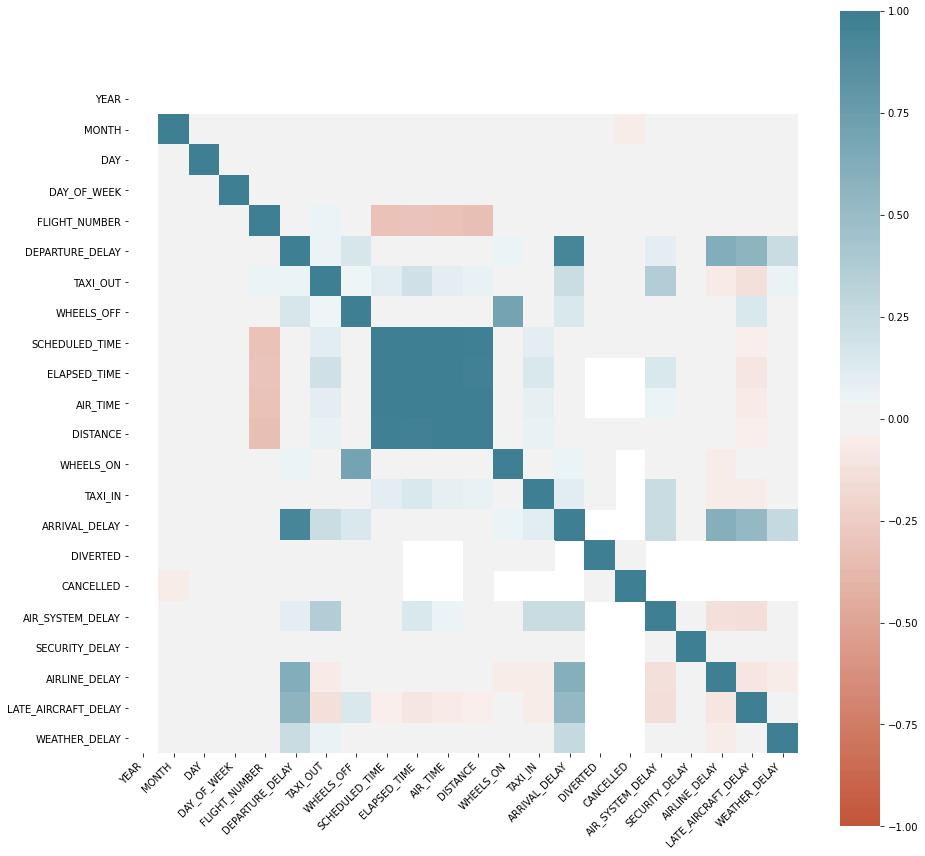

In [ ]:
corr = df.corr()
plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')

## Analyzing from correlation
We found that features like TAXI_OUT, TAXI_IN, WHEELS_ON, WHEELS_OFF, etc have no correlation with other features. So, we are dropping it out.


In [ ]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


# Extracting Some Info from dataset

In [ ]:
abbr_companies = airlines_data.set_index('IATA_CODE')['AIRLINE'].to_dict()

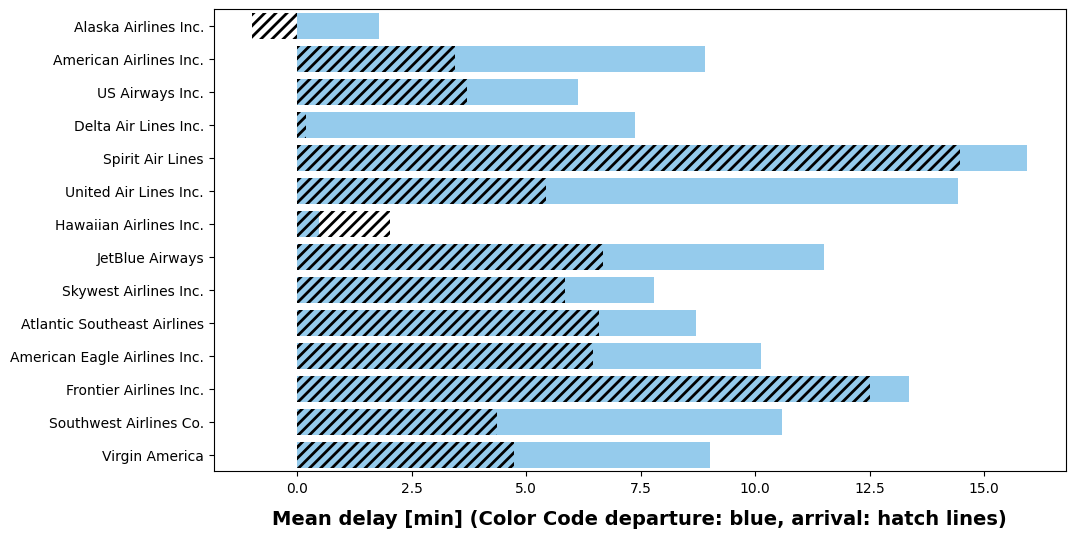

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (Color Code departure: blue, arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [ ]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-24.0,644.0,61385.0,9.022595
HA,-27.0,1433.0,76119.0,0.485713
F9,-46.0,1112.0,90290.0,13.350858
NK,-37.0,836.0,115454.0,15.944766
AS,-82.0,963.0,171910.0,1.785801
US,-35.0,759.0,194825.0,6.141137
B6,-31.0,1006.0,262843.0,11.514353
MQ,-36.0,1544.0,280282.0,10.125188
UA,-40.0,1314.0,509534.0,14.435441


# Number of flights with delay as small and large and on-time

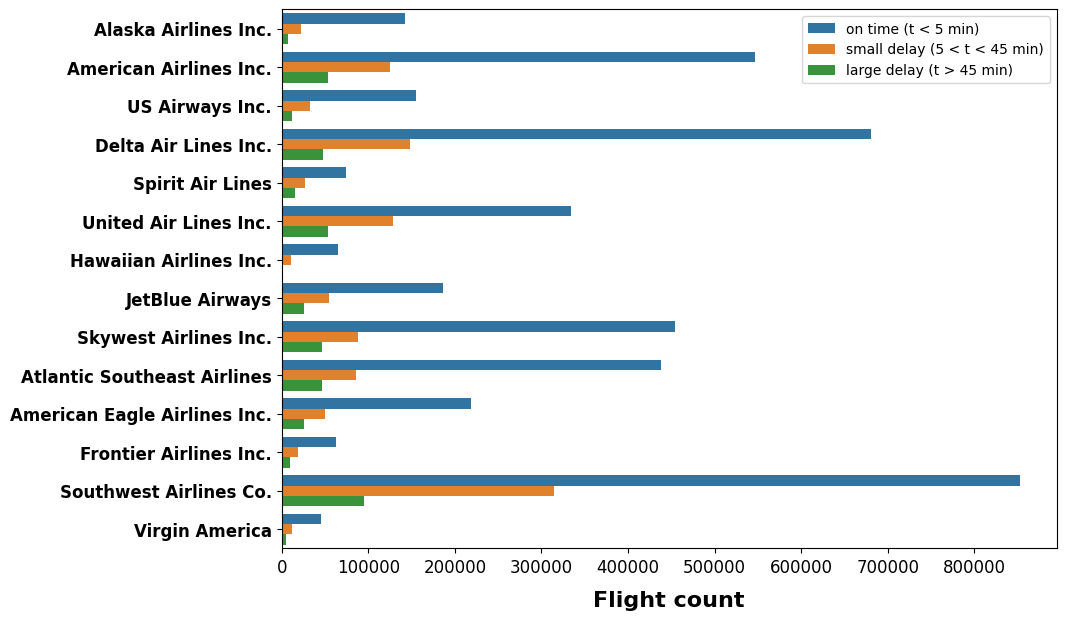

In [ ]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

## Predicting Flight Delay 
### Used American Airline (AA) for predicting

Taken training set before date 4th April, 2015 and trying to predict delay after that Date.

In [ ]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 4, 4)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 4, 4)]
df = df_train
df['SCHEDULED_DEPARTURE']

0         2015-01-01 00:05:00
1         2015-01-01 00:10:00
2         2015-01-01 00:20:00
3         2015-01-01 00:20:00
4         2015-01-01 00:25:00
                  ...        
1454081   2015-04-03 23:59:00
1454082   2015-04-03 23:59:00
1454083   2015-04-03 23:59:00
1454084   2015-04-03 23:59:00
1454085   2015-04-03 23:59:00
Name: SCHEDULED_DEPARTURE, Length: 1454086, dtype: datetime64[ns]

In [ ]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h beacuse it will be outlier and can affect the accuracy of model
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['formated_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['formated_depart'] = df2['formated_depart'].apply(fct)
    df2['formated_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['formated_depart', 'formated_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [ ]:
carrier = 'US'
df3 = create_df(df, carrier)    
df3[:5]

,formated_depart,formated_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,600,22440,SLC,7.333333,3.0
1,900,4500,CLT,-5.000000,6.0
2,900,5220,CLT,-4.000000,6.0
3,900,7680,CLT,-5.000000,6.0
4,900,20940,PHX,-3.000000,1.0


In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['formated_depart', 'formated_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 3.5758e+24
n=1 alpha=0.2 , MSE = 47.611
n=1 alpha=0.4 , MSE = 47.879
n=1 alpha=0.6 , MSE = 48.18
n=1 alpha=0.8 , MSE = 48.482
n=1 alpha=1.0 , MSE = 48.772
n=1 alpha=1.2 , MSE = 49.043
n=1 alpha=1.4 , MSE = 49.296
n=1 alpha=1.6 , MSE = 49.529
n=1 alpha=1.8 , MSE = 49.744
n=2 alpha=0.0 , MSE = 6.1455e+25
n=2 alpha=0.2 , MSE = 47.174
n=2 alpha=0.4 , MSE = 47.278
n=2 alpha=0.6 , MSE = 47.384
n=2 alpha=0.8 , MSE = 47.489
n=2 alpha=1.0 , MSE = 47.592
n=2 alpha=1.2 , MSE = 47.695
n=2 alpha=1.4 , MSE = 47.799
n=2 alpha=1.6 , MSE = 47.902
n=2 alpha=1.8 , MSE = 48.004


\begin{eqnarray}
y_i - f(x_i) = \sqrt{MSE}
\end{eqnarray}

### It is actually giving the average delay.


In [ ]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

51.103457143821146


# Testing

In [ ]:
def predictMeanDelay(airline):
  carrier = airline
  df3 = create_df(df, carrier)    
  df3[:5]
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
  #_________________________________________________________
  zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
  label_airports = list(set(list(zipped)))
  label_airports.sort(key = lambda x:x[0])
  #_________________________________________________
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  #_________________________________________________
  b = np.array(df3[['formated_depart', 'formated_arrivee']])
  X = np.hstack((onehot_encoded, b))
  Y = np.array(df3['DEPARTURE_DELAY'])
  Y = Y.reshape(len(Y), 1)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
  score_min = 10000
  for pol_order in range(1, 3):
      for alpha in range(0, 20, 2):
          ridgereg = Ridge(alpha = alpha/10, normalize=True)
          poly = PolynomialFeatures(degree = pol_order)
          regr = linear_model.LinearRegression()
          X_ = poly.fit_transform(X_train)
          ridgereg.fit(X_, Y_train)
          
          X_ = poly.fit_transform(X_test)
          result = ridgereg.predict(X_)
          score = metrics.mean_squared_error(result, Y_test)
          
          if score < score_min:
              score_min = score
              parameters = [alpha, pol_order]

          #print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))
  ridgereg = Ridge(alpha = parameters[0], normalize=True)
  poly = PolynomialFeatures(degree = parameters[1])
  X_ = poly.fit_transform(X)
  ridgereg.fit(X_, Y)
  result = ridgereg.predict(X_)
  score = metrics.mean_squared_error(result, Y)        
  #print(score)
  df3 = create_df(df_test, carrier)    
  df3[:5]
  label_conversion = dict()
  for s in label_airports:
      label_conversion[s[1]] = s[0]

  df3['ORIGIN_AIRPORT'].replace(label_conversion, inplace = True)

  for index, label in label_airports:
      temp = df3['ORIGIN_AIRPORT'] == index
      temp = temp.apply(lambda x:1.0 if x else 0.0)
      if index == 0:
          matrix = np.array(temp)
      else:
          matrix = np.vstack((matrix, temp))
  matrix = matrix.T

  b = np.array(df3[['formated_depart', 'formated_arrivee']])
  X_test = np.hstack((matrix, b))
  Y_test = np.array(df3['DEPARTURE_DELAY'])
  Y_test = Y_test.reshape(len(Y_test), 1)
  X_ = poly.fit_transform(X_test)
  result = ridgereg.predict(X_)
  score = metrics.mean_squared_error(result, Y_test)
  #print('MSE = {}'.format(round(score, 2)))
  result = 'Avg Delay expected is {:.2f} min'.format(np.sqrt(score))
  return result

In [ ]:
predictMeanDelay('US')

'Avg Delay expected is 5.96 min'

In [ ]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask, request, redirect, url_for, jsonify
import random
app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run

airlinesList = ['US','UA','AA','F9','B6']

@app.route("/")
def home():
  return "Hello from the other side :)"
@app.route("/getAccuracy")
def get_accuracy():
  return str("Farji data")
@app.route("/dataSent")
def showDataReceived(name):
  return jsonify(name)
@app.route("/sendFormData", methods=['POST','GET'])
def getFormData():
  if request.method == 'POST' :
    dateTime = request.form['dateTime']
    origin = request.form['origin']
    destination = request.form['dest']
    
  if request.method == "GET" :
    dateTime = request.args.get('dateTime')
    origin = request.args.get('origin')
    destination = request.args.get('dest')
  return predictMeanDelay(random.choice(airlinesList))
  # return redirect(url_for("get_accuracy",dateTime=dateTime,origin=origin,destination=destination))
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://2cecac0e.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


# Using other model

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.isnull().values.any()

In [ ]:
df.isnull().sum()

In [ ]:
df[df.isnull().values.any(axis=1)].head()

In [ ]:
df = df.fillna({'ARRIVAL_DELAY': 1})
df.iloc[177:185]

In [ ]:
df.head()

In [ ]:
import math

for index, row in df.iterrows():
    df.loc[index, 'SCHEDULED_TIME'] = math.floor(row['SCHEDULED_TIME'] / 100)
df.head()